In [83]:
# importing relevant modules
import matplotlib.pyplot   as plt

from pandas                import read_csv, to_datetime
from numpy                 import reshape
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models          import Sequential
from keras.layers          import Dense, Dropout, LSTM
from keras_tqdm            import TQDMNotebookCallback

%matplotlib inline

In [84]:
# Currency conversion.
Yen_To_USD = lambda p: p*0.0094

In [85]:
# Import the dataset and encode the date
dataFiles     = ['bitflyerJPY_1-min_data_2017-07-04_to_2018-03-27.csv', 'coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv',
                 'coincheckJPY_1-min_data_2014-10-31_to_2018-03-27.csv', 'bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv']
file          = 0
df            = read_csv('../data/' + dataFiles[file])
# Append 'date' column to our dataframe.
df['date']    = to_datetime(df['Timestamp'],unit='s').dt.date
# Store the average weighted price per day.
daily_average = [df.groupby('date')['Weighted_Price'].mean().apply(Yen_To_USD), df.groupby('date')['Weighted_Price'].mean()][file%2]

In [86]:
#Partition the data set into training and testing sets.
split                 = 0.3
partition             = -int(split*len(daily_average))
train_data, test_data = daily_average[:partition], daily_average[partition:]

We will now perform min-max scaling on the training data and then construct an LSTM network to make predictions for the remainder of our data. After this, we will compare our model's predicted price values to that of the testing data set.

In [87]:
# Form training set from daily averages.
training_set, testing_set = train_data.values, test_data.values
training_set, testing_set = reshape(training_set, (len(training_set), 1)), reshape(testing_set, (len(testing_set), 1))

# Perform Min-max scaling.
sc1, sc2                  = MinMaxScaler(), MinMaxScaler()
training_set, testing_set = sc1.fit_transform(training_set), sc2.fit_transform(testing_set)

# Create four new arrays, the x arrays are a day behind the y arrays.
x_train, y_train          = training_set[:-1], training_set[1:]
x_test,  y_test           = testing_set[:-1], testing_set[1:]
x_train                   = reshape(x_train, (len(x_train), 1, 1))
x_test                    = reshape(x_test, (len(x_test), 1, 1))

In [88]:
# Building the model
lstm_units = 100
model      = Sequential()

model.add(LSTM(units            = lstm_units,
               return_sequences = True,
               input_shape      = (None, 1)))

model.add(Dropout(0.2))
    
model.add(LSTM(units            = lstm_units,
               return_sequences = False))

model.add(Dropout(0.2))

model.add(Dense(units      = 1,
                activation = 'linear'))

model.compile(loss      = 'mean_squared_error',
              optimizer = 'rmsprop',
              metrics   = ['accuracy'])

# Fitting the RNN to the Training set
history = model.fit(x                = x_train,
                    y                = y_train,
                    batch_size       = len(x_train),
                    epochs           = 100,
                    validation_split = 0.2,
                    verbose          = 0,
                    callbacks=[TQDMNotebookCallback()])

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=148), HTML(value='')))

In [89]:
# Comparing our model's output, given the training data, to the expected output.
actual_prices_train       = sc1.inverse_transform(y_train)[:-1]
predicted_BTC_price_train = sc1.inverse_transform(model.predict(x_train))[1:]

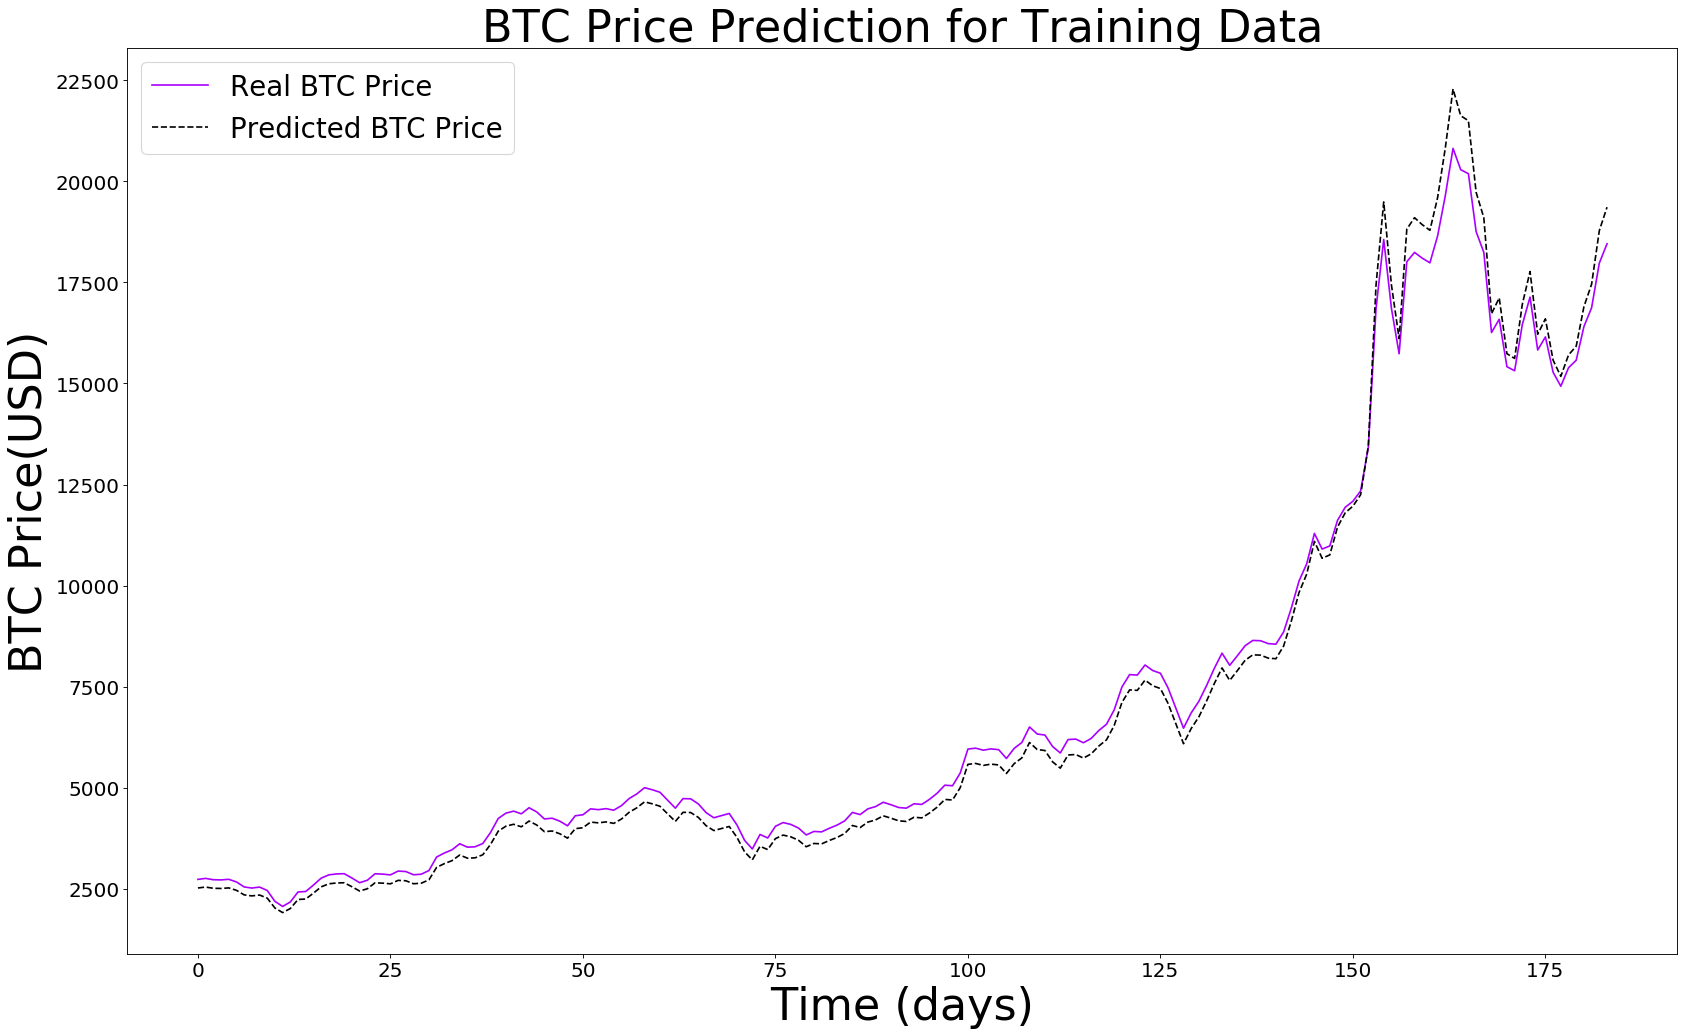

In [90]:
# Visualising the results
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax = plt.gca()

plt.plot(actual_prices_train, 
         color = '#AA00FF',
         label = 'Real BTC Price')
plt.plot(predicted_BTC_price_train,
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted BTC Price')

plt.title('BTC Price Prediction for Training Data',
          fontsize = 40)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time (days)',
           fontsize = 40)
plt.ylabel('BTC Price(USD)',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()

Even more interesting than looking at the average daily price prediction is looking at the predicted average daily price percent change as compared to that of the actual average daily price percent change; we will do this below.

In [91]:
predicted_percent_change_train = [100*(e2[0] - e1[0])/e1[0] for e1, e2 in zip(predicted_BTC_price_train[:-1], predicted_BTC_price_train[1:])]
actual_percent_change_train    = [100*(e2 - e1)/e1 for e1, e2 in zip(actual_prices_train[:-1], actual_prices_train[1:])]

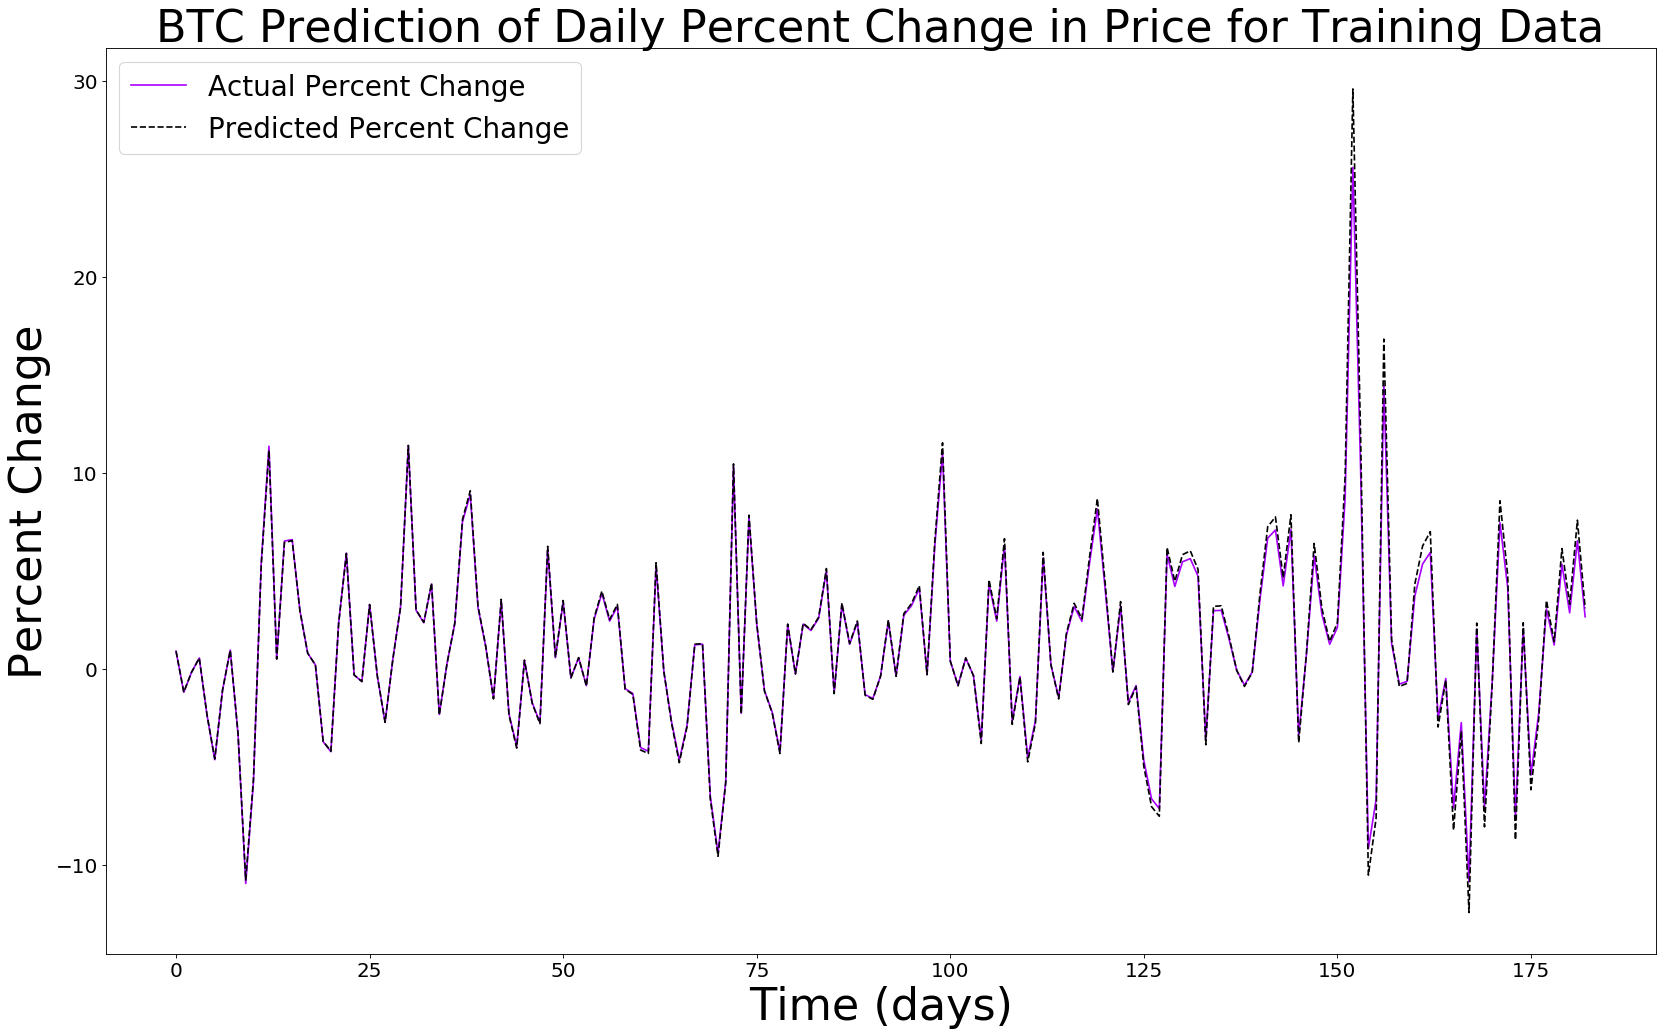

In [92]:
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax = plt.gca()

plt.plot(actual_percent_change_train, 
         color = '#AA00FF',
         label = 'Actual Percent Change')
plt.plot(predicted_percent_change_train,
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted Percent Change')

plt.title('BTC Prediction of Daily Percent Change in Price for Training Data',
          fontsize = 40)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time (days)',
           fontsize = 40)
plt.ylabel('Percent Change',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()

In [93]:
#Predicting the future.
actual_prices_test       = sc2.inverse_transform(y_test)[:-1]
predicted_BTC_price_test = sc2.inverse_transform(model.predict(x_test))[1:]

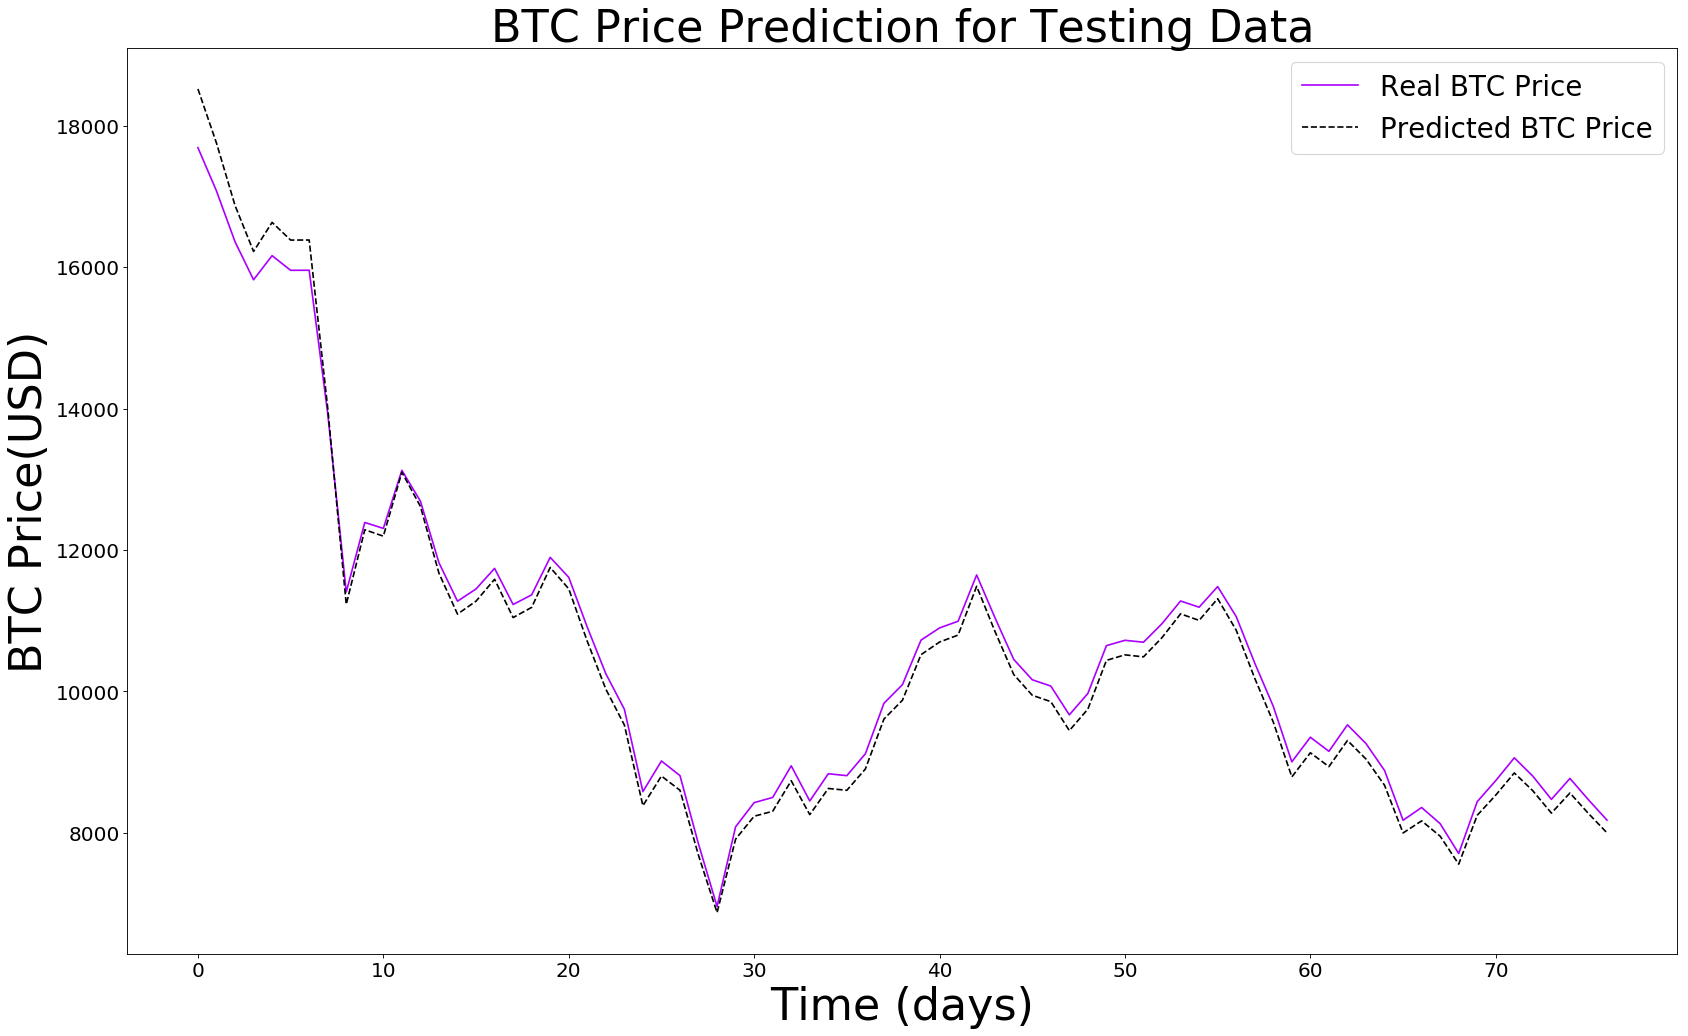

In [94]:
# Visualising the results
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax = plt.gca()

plt.plot(actual_prices_test, 
         color = '#AA00FF',
         label = 'Real BTC Price')
plt.plot(predicted_BTC_price_test,
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted BTC Price')

plt.title('BTC Price Prediction for Testing Data',
          fontsize = 40)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time (days)',
           fontsize = 40)
plt.ylabel('BTC Price(USD)',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()

In [95]:
predicted_percent_change_test = [100*(e2[0] - e1[0])/e1[0] for e1, e2 in zip(predicted_BTC_price_test[:-1], predicted_BTC_price_test[1:])]
actual_percent_change_test    = [100*(e2 - e1)/e1 for e1, e2 in zip(actual_prices_test[:-1], actual_prices_test[1:])]

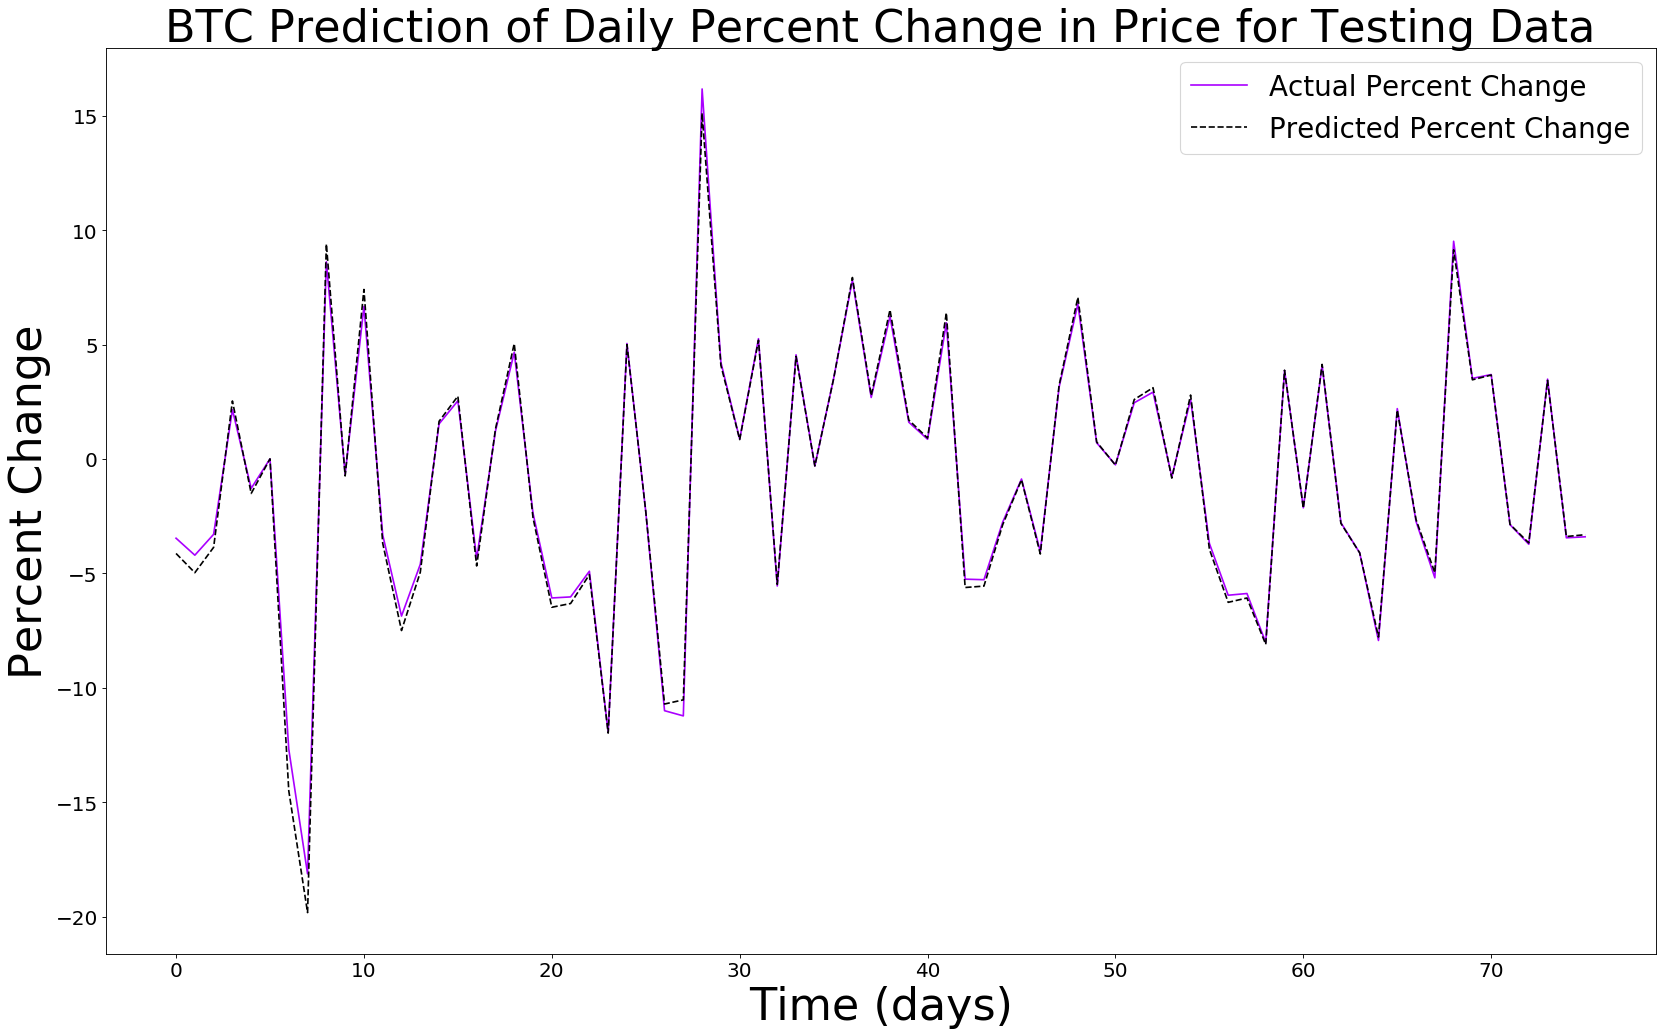

In [96]:
plt.figure(figsize   = (25,15),
           dpi       = 80,
           facecolor = 'w',
           edgecolor = 'k')

ax = plt.gca()

plt.plot(actual_percent_change_test, 
         color = '#AA00FF',
         label = 'Actual Percent Change')
plt.plot(predicted_percent_change_test,
         color = '#000000',
         ls    = 'dashed',
         label = 'Predicted Percent Change')

plt.title('BTC Prediction of Daily Percent Change in Price for Testing Data',
          fontsize = 40)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
plt.xlabel('Time (days)',
           fontsize = 40)
plt.ylabel('Percent Change',
           fontsize = 40)
plt.legend(loc  = 'best',
           prop = {'size': 25})

plt.show()